## Mount the google drive

In [27]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Write a sample to test
with open('to_upload.txt', 'w') as f:
  f.write('my sample file')
  

ModuleNotFoundError: No module named 'google'

In [28]:
with open('drive/My Drive/Colab Notebooks/foo.txt', 'w') as f:
  f.write('I am a foo')

FileNotFoundError: [Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/foo.txt'

## Using Locally

In [13]:
# Question 1
import pandas as pd
import numpy as np
import json
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import pytz

# Question 3
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Question 8
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

In [14]:
google_file_direct = "drive/My Drive/Colab Notebooks/ECE219_tweet_data/"
file_direct = ""

## How to load json data

In [53]:
json_objects = list()
filename = "updated_tweets_#gopatriots.txt"
with open(file_direct + filename, "r") as file:
    line = file.readline()
    while line:
        json_objects.append(json.loads(line))
        line = file.readline()

In [54]:
def getJsonObjects(filename):
    json_list = list()
    with open(file_direct + filename, "r") as jsonfile:
        line = jsonfile.readline()
        while line:
            json_list.append(json.loads(line))
            line = jsonfile.readline()
        return json_list

# list_cnt = 0
def creationTimeParser(unix_time, time_zone = pytz.timezone('America/Los_Angeles')):
    date_object = datetime.datetime.fromtimestamp(unix_time, time_zone)
    date_object = date_object.replace(minute=0, second=0, microsecond=0)
    return date_object
  

def getStat(json_objects, hr2cnt):
    # Description:
    # Get the the number of tweets, also features forom the tweet
    list_cnt = 0
    total_followers = 0
    total_tweets = 0
    time_zone = pytz.timezone('America/Los_Angeles')
    for i in range(len(json_objects)):
    # parse the avg tweet per hour
        parsed_time = creationTimeParser(json_objects[i]['citation_date'],  time_zone)
        if parsed_time in hr2cnt:
          hr2cnt[parsed_time] += 1
        else:
          hr2cnt[parsed_time] = 1
        total_followers += json_objects[i]['followers']
        total_tweets += json_objects[i]['total_citations']
    min_time = min(hr2cnt.keys())
    max_time = max(hr2cnt.keys())
    hour_time = min_time + timedelta(hours=1)
    while hour_time < max_time:
        if hour_time not in hr2cnt:
            hr2cnt[hour_time] = 0
        hour_time = hour_time + timedelta(hours=1)
    hr_np = np.fromiter(hr2cnt.values(), dtype=np.int).reshape((len(hr2cnt),1))
    min_time = min(hr2cnt.keys())
    max_time = max(hr2cnt.keys())
    diff_time = max_time - min_time + timedelta(hours=1)
    avg_tweets = hr_np.sum() / (diff_time.total_seconds()/3600)
    print("total retweets: ", total_tweets, "len jsob_obj: ", len(json_objects))
    return {'avg tweets per hour' : avg_tweets, 
          'avg followers per tweet' : total_followers / len(json_objects),
          'avg retweets per tweet' : total_tweets / len(json_objects)}

In [55]:
# creationTimeParser(json_objects[0]['citation_date'])
# print(type(json_objects[0]))
hr2cnt = dict()
getStat(json_objects, hr2cnt)

total retweets:  33108 len jsob_obj:  23511


{'avg followers per tweet': 1427.2526051635405,
 'avg retweets per tweet': 1.4081919101697078,
 'avg tweets per hour': 40.888695652173915}

## Question 2

In [56]:
json_objects_patroits = getJsonObjects(filename)
hr2cnt_patriots = dict()
superbowl_stat = getStat(json_objects_patroits, hr2cnt_patriots)

total retweets:  33108 len jsob_obj:  23511


In [57]:
def getTweetCount(json_objects):
    hr2cnt = dict()
    stat = getStat(json_objects, hr2cnt)
    return hr2cnt
    
def getSortedKeys(hr2cnt):
    keylist = sorted(hr2cnt.keys())
    return keylist

# TODO: change the x ticks to display properly
def generatePlot(hr2cnt, tag_name):
    sorted_time = getSortedKeys(hr2cnt)
    sorted_vals = [hr2cnt[x] for x in sorted_time]
    plt.plot(sorted_time, sorted_vals)
    print("sorted_vals: ", len(sorted_vals))
    plt.xlabel('time')
    plt.ylabel('num of posts')
    plt.title("Tag Name: " + tag_name)
    plt.show()

def Question2(json_objects, tag_name):
    hr2cnt = getTweetCount(json_objects)
    keylist = getSortedKeys(hr2cnt)
    generatePlot(hr2cnt, tag_name)

total retweets:  33108 len jsob_obj:  23511
sorted_vals:  575


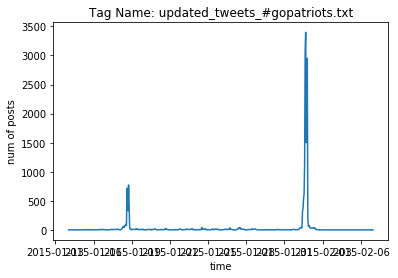

In [58]:
Question2(json_objects_patroits, filename)

## Question 3

In [59]:
# TODO: Still need to check whether I got the right number
# refactor the code to make it easy to use for different files

In [70]:
def featureExtraction(json_objects):
    hr2feature = dict()
    for i in range(len(json_objects)):
        parsed_time = creationTimeParser(json_objects[i]['citation_date'])
        if parsed_time in hr2feature:
            hr2feature[parsed_time]["num_tweets"] += 1
            hr2feature[parsed_time]["num_retweets"] += json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] += json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = max(hr2feature[parsed_time]["max_followers"], json_objects[i]['followers'])
        else:
            hr2feature[parsed_time] = dict()
            hr2feature[parsed_time]["hr_of_day"] = parsed_time.hour
            hr2feature[parsed_time]["num_tweets"] = 1
            hr2feature[parsed_time]["num_retweets"] = json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] = json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = json_objects[i]['followers']
    min_time = min(hr2feature.keys())
    max_time = max(hr2feature.keys())
    hour_time = min_time + timedelta(hours=1)
    while hour_time < max_time:
        if hour_time not in hr2feature:
            hr2feature[hour_time] = dict()
            hr2feature[hour_time]["hr_of_day"] = hour_time.hour
            hr2feature[hour_time]["num_tweets"] = 0
            hr2feature[hour_time]["num_retweets"] = 0
            hr2feature[hour_time]["num_followers"] = 0
            hr2feature[hour_time]["max_followers"] = 0
        hour_time += timedelta(hours=1)
    return hr2feature

feature_list = ['hr_of_day', 'max_followers', 'num_followers', 'num_retweets', 'num_tweets', 'next_num_tweets']

# convert a dictionary to numpy array
def convertDictToNumpy(parsed_features, feature_list):
    df = pd.DataFrame(parsed_features).T.sort_index()
    # create the label column
    df["next_num_tweets"] = df["num_tweets"].shift(-1)
    df = df[feature_list] # reorder the column based on feature
    df.drop(df.tail(1).index, inplace=True)
    train_set = df.values[:,:-1]
    labels = df.values[:,-1]
    labels = labels.reshape((len(labels), 1))
    return {"features" : train_set, "labels" : labels}

def trainAndEvaluate(train_labels_pair, feature_list):
    # OLS Top three features and P values
    x_train = np.squeeze(sm.add_constant(train_labels_pair["features"]))
    y_train = np.squeeze(train_labels_pair["labels"])
    ols = sm.OLS(y_train, x_train)
    res_vals = ols.fit()
    pred_vals = res_vals.predict(x_train)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_train, pred_vals))
    print("P values: ", res_vals.pvalues)
    idx_pvals_pair = list()
    print ("pvals shape: ", res_vals.pvalues.shape)
    for i in range(res_vals.pvalues.shape[0]):
        pair = (res_vals.pvalues[i], i)
        idx_pvals_pair.append(pair)
    idx_pvals_pair = sorted(idx_pvals_pair, key=lambda x: if x[1] == 0: 6666 else x[0])
    print(idx_pvals_pair)
    print("Top three features")
    for i in range(3):
        print("index val: ", idx_pvals_pair[i][1]-1)
        print("feature:", feature_list[idx_pvals_pair[i][1]-1], ", P value:", idx_pvals_pair[i][0])
    print ("summary: ", res_vals.summary())
    return
    

SyntaxError: invalid syntax (<ipython-input-70-6972de6f8a40>, line 60)

In [71]:
# Running Question 3
parsed_features = featureExtraction(json_objects)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list)
trainAndEvaluate(train_labels_pair, feature_list)

Mean squared error: 27587.45
P values:  [0.4948699  0.84490848 0.92929918 0.59944679 0.00983758 0.28376498]
pvals shape:  (6,)
[(0.009837577114207028, 4), (0.2837649750482316, 5), (0.49486990067531256, 0), (0.5994467858735322, 3), (0.8449084844010921, 1), (0.9292991810103117, 2)]
Top three features
index val:  3
feature: num_retweets , P value: 0.009837577114207028
index val:  4
feature: num_tweets , P value: 0.2837649750482316
index val:  -1
feature: next_num_tweets , P value: 0.49486990067531256
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     192.9
Date:                Thu, 14 Mar 2019   Prob (F-statistic):          6.97e-120
Time:                        22:12:16   Log-Likelihood:                -3749.1
No. Observati

## Question 4

### Selected Features
count of happy emojis
count of sad emojis
url count
user mentioned count


In [42]:
feature_list_updated = ['hr_of_day', 'max_followers', 
                        'num_followers', 'num_retweets', 
                        'happy_emoji_cnt', 'sad_emoji_cnt', 
                        'user_mentioned_cnt', 'url_cnt', 
                        'num_tweets', 'next_num_tweets']
def featureExtractionCustomized(json_objects):
    hr2feature = dict()
    happy_emoji = [":)", ":-)", ":')", ":]", "=]", ":)"]
    sad_emoji = [":-(", ":'(", ":[", "=["]
    
    for i in range(len(json_objects)):
        parsed_time = creationTimeParser(json_objects[i]['citation_date'])
        tweet_text = json_objects[i]['text']
        if parsed_time in hr2feature:
            hr2feature[parsed_time]["num_tweets"] += 1
            hr2feature[parsed_time]["num_retweets"] += json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] += json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = max(hr2feature[parsed_time]["max_followers"], json_objects[i]['followers'])
            hr2feature[parsed_time]["user_mentioned_cnt"] += json_objects[i]['user_mentioned_cnt']
            hr2feature[parsed_time]["url_cnt"] += json_objects[i]['url_cnt']
        else:
            hr2feature[parsed_time] = dict()
            hr2feature[parsed_time]["hr_of_day"] = parsed_time.hour
            hr2feature[parsed_time]["num_tweets"] = 1
            hr2feature[parsed_time]["num_retweets"] = json_objects[i]['total_citations']
            hr2feature[parsed_time]["num_followers"] = json_objects[i]['followers']
            hr2feature[parsed_time]["max_followers"] = json_objects[i]['followers']
            hr2feature[parsed_time]["happy_emoji_cnt"] = 0
            hr2feature[parsed_time]["sad_emoji_cnt"] = 0
            hr2feature[parsed_time]["user_mentioned_cnt"] = json_objects[i]['user_mentioned_cnt']
            hr2feature[parsed_time]["url_cnt"] = json_objects[i]['url_cnt']
        
        if hasEmoticon(happy_emoji, tweet_text):
            hr2feature[parsed_time]["happy_emoji_cnt"] += 1
        if hasEmoticon(sad_emoji, tweet_text):
            hr2feature[parsed_time]["sad_emoji_cnt"] += 1
            
    min_time = min(hr2feature.keys())
    max_time = max(hr2feature.keys())
    hour_time = min_time + timedelta(hours=1)
    while hour_time < max_time:
        if hour_time not in hr2feature:
            hr2feature[hour_time] = dict()
            hr2feature[hour_time]["hr_of_day"] = hour_time.hour
            hr2feature[hour_time]["num_tweets"] = 0
            hr2feature[hour_time]["num_retweets"] = 0
            hr2feature[hour_time]["num_followers"] = 0
            hr2feature[hour_time]["max_followers"] = 0
            hr2feature[hour_time]["sad_emoji_cnt"] = 0
            hr2feature[hour_time]["happy_emoji_cnt"] = 0
            hr2feature[hour_time]["user_mentioned_cnt"] = 0
            hr2feature[hour_time]["url_cnt"] = 0
            
        hour_time += timedelta(hours=1)
    return hr2feature

def hasEmoticon(emoji_list, tweet_text):
    for emoji in emoji_list:
        if emoji in tweet_text:
            return True
    return False

In [43]:
# Running Question 4
parsed_features = featureExtractionCustomized(json_objects)
train_labels_pair = convertDictToNumpy(parsed_features, feature_list_updated)
trainAndEvaluate(train_labels_pair, feature_list_updated)

Mean squared error: 9316.57
P values:  [4.66524600e-01 7.13371471e-01 8.17523013e-07 1.77126782e-05
 8.36454435e-06 9.10207353e-81 3.40795634e-01 1.33152057e-73
 1.27759863e-07 1.10736365e-01]
[(9.102073527182206e-81, 5), (1.3315205667309248e-73, 7), (1.2775986286075584e-07, 8), (8.175230133816726e-07, 2), (8.364544353672544e-06, 4), (1.7712678221146835e-05, 3), (0.11073636496520672, 9), (0.3407956344262053, 6), (0.46652460039975874, 0), (0.7133714710757046, 1)]
Top three features
feature: sad_emoji_cnt , P value: 9.102073527182206e-81
feature: url_cnt , P value: 1.3315205667309248e-73
feature: num_tweets , P value: 1.2775986286075584e-07
summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     438.0
Date:                Thu, 1

## Problem 8 Ensemble Method

In [392]:
parameters = {'max_depth': [10, 20, 40, 60, 80, 100, 200, None], 
 'max_features': ['auto', 'sqrt'], 
 'min_samples_leaf': [1, 2, 4], 
 'min_samples_split': [2, 5, 10], 
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
clf = RandomForestRegressor()
grid_search = GridSearchCV(clf, param_grid=parameters, cv=KFold(5, shuffle=True), scoring='neg_mean_squared_error')
# OLS Top three features and P values
x_train = np.squeeze(sm.add_constant(train_labels_pair["features"]))
y_train = np.squeeze(train_labels_pair["labels"])

In [ ]:
# grid_search.fit(x_train, y_train)